##  Team Members

- # Taksh Pal (24/B03/048) 
- # Ritij Raj (24/B03/015)
# SAR to EO Image Translation using CycleGAN

This project implements a **Cycle-Consistent Generative Adversarial Network (CycleGAN)** for translating **Synthetic Aperture Radar (SAR)** satellite images to **Electro-Optical (EO)** images. The goal is to generate visually realistic EO images from SAR data, which is often more available in cloudy or night-time conditions where optical sensors fail.

---

## Key Features

- ✅ **CycleGAN architecture**: Unpaired image-to-image translation without requiring one-to-one image mapping.
- ✅ **4-channel EO outputs**: Including NIR, Red, Green, and Blue channels.
- ✅ **False-color visualization**: Displays NIR as Red to highlight vegetation and land features.
- ✅ **PSNR & SSIM Evaluation**: Quantitative metrics for image quality comparison.
- ✅ **Custom dataloader**: Handles 2-channel SAR and 4-channel EO imagery.
- ✅ **Training on Kaggle GPUs**: Easily reproducible on Kaggle platform.

---

## Evaluation Metrics

- **PSNR (Peak Signal-to-Noise Ratio)**: Measures image fidelity.
- **SSIM (Structural Similarity Index)**: Captures perceptual similarity.

Both metrics are calculated per image and averaged over the test set. Sample outputs are visualized using a false-color scheme:

## References

- [CycleGAN Paper (Zhu et al.)](https://arxiv.org/abs/1703.10593)
- [PyTorch Implementation](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

In [1]:
import os
import numpy as np
!pip install rasterio
import rasterio
from tqdm import tqdm
from rasterio.errors import RasterioIOError
from PIL import Image

# --- Input folders ---
sar_folder = '/kaggle/input/sar2eo50/content/data_small/s1'
eo_folder  = '/kaggle/input/sar2eo50/content/data_small/s2'

# --- Output folders ---
out_sar = '/kaggle/working/processed_sar'
out_eo  = '/kaggle/working/processed_eo'
os.makedirs(out_sar, exist_ok=True)
os.makedirs(out_eo, exist_ok=True)

# --- Target size ---
target_size = (256, 256)

def process_and_save(image_path, out_path, is_sar=True):
    with rasterio.open(image_path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)

    # Normalize to [0, 1]
    img -= img.min()
    img /= (img.max() + 1e-6)

    if is_sar:
        # Expecting at least 2 bands (VV, VH)
        if img.shape[0] >= 2:
            vv, vh = img[0], img[1]
            img = np.stack([vv, vh], axis=-1)  # (H, W, 2)
        else:
            raise ValueError(f"SAR needs ≥2 bands, got {img.shape[0]}")
    else:
        # EO: pick B4, B3, B2, B8 → indices 3,2,1,7
        if img.shape[0] >= 12:
            red   = img[3]
            green = img[2]
            blue  = img[1]
            nir   = img[7]
            img = np.stack([red, green, blue, nir], axis=-1)  # (H, W, 4)
        else:
            raise ValueError(f"EO needs ≥12 bands, got {img.shape[0]}")

    # Resize each channel via PIL
    img = np.moveaxis(img, -1, 0)  # (C, H, W)
    resized = np.zeros((img.shape[0], *target_size), dtype=np.float32)
    for i in range(img.shape[0]):
        band = Image.fromarray((img[i] * 255).astype(np.uint8))
        band = band.resize(target_size)
        resized[i] = np.array(band) / 255.0

    # back to (H, W, C)
    img = np.moveaxis(resized, 0, -1)

    # Save as .npy
    np.save(out_path, img)

# --- Run preprocessing ---
filenames = sorted(os.listdir(sar_folder))[:200]
skipped = 0
for fname in tqdm(filenames):
    sar_path = os.path.join(sar_folder, fname)
    eo_path  = os.path.join(eo_folder,  fname.replace('s1', 's2'))

    out_sar_path = os.path.join(out_sar, fname.replace('.tif', '.npy'))
    out_eo_path  = os.path.join(out_eo,  fname.replace('.tif', '.npy'))

    try:
        process_and_save(sar_path, out_sar_path, is_sar=True)
        process_and_save(eo_path,  out_eo_path,  is_sar=False)
    except (RasterioIOError, ValueError) as e:
        print(f"⚠️ Skipping {fname}: {e}")
        skipped += 1

print(f"\n✅ Done. Skipped {skipped}, saved SAR: {len(os.listdir(out_sar))}, EO: {len(os.listdir(out_eo))}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.0 MB/s eta 0:00:00


100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


✅ Done. Skipped 0, saved SAR: 200, EO: 200


In [2]:
import numpy as np

# Example path to your processed files
sample_sar = np.load('/kaggle/working/processed_eo/ROIs2017_winter_s1_102_p134.npy')
sample_eo = np.load('/kaggle/working/processed_sar/ROIs2017_winter_s1_102_p134.npy')

print("SAR range:", sample_sar.min(), "to", sample_sar.max())
print("EO range:", sample_eo.min(), "to", sample_eo.max())
print("SAR dtype:", sample_sar.dtype)
print("EO dtype:", sample_eo.dtype)


SAR range: 0.105882354 to 0.91764706
EO range: 0.0 to 1.0
SAR dtype: float32
EO dtype: float32


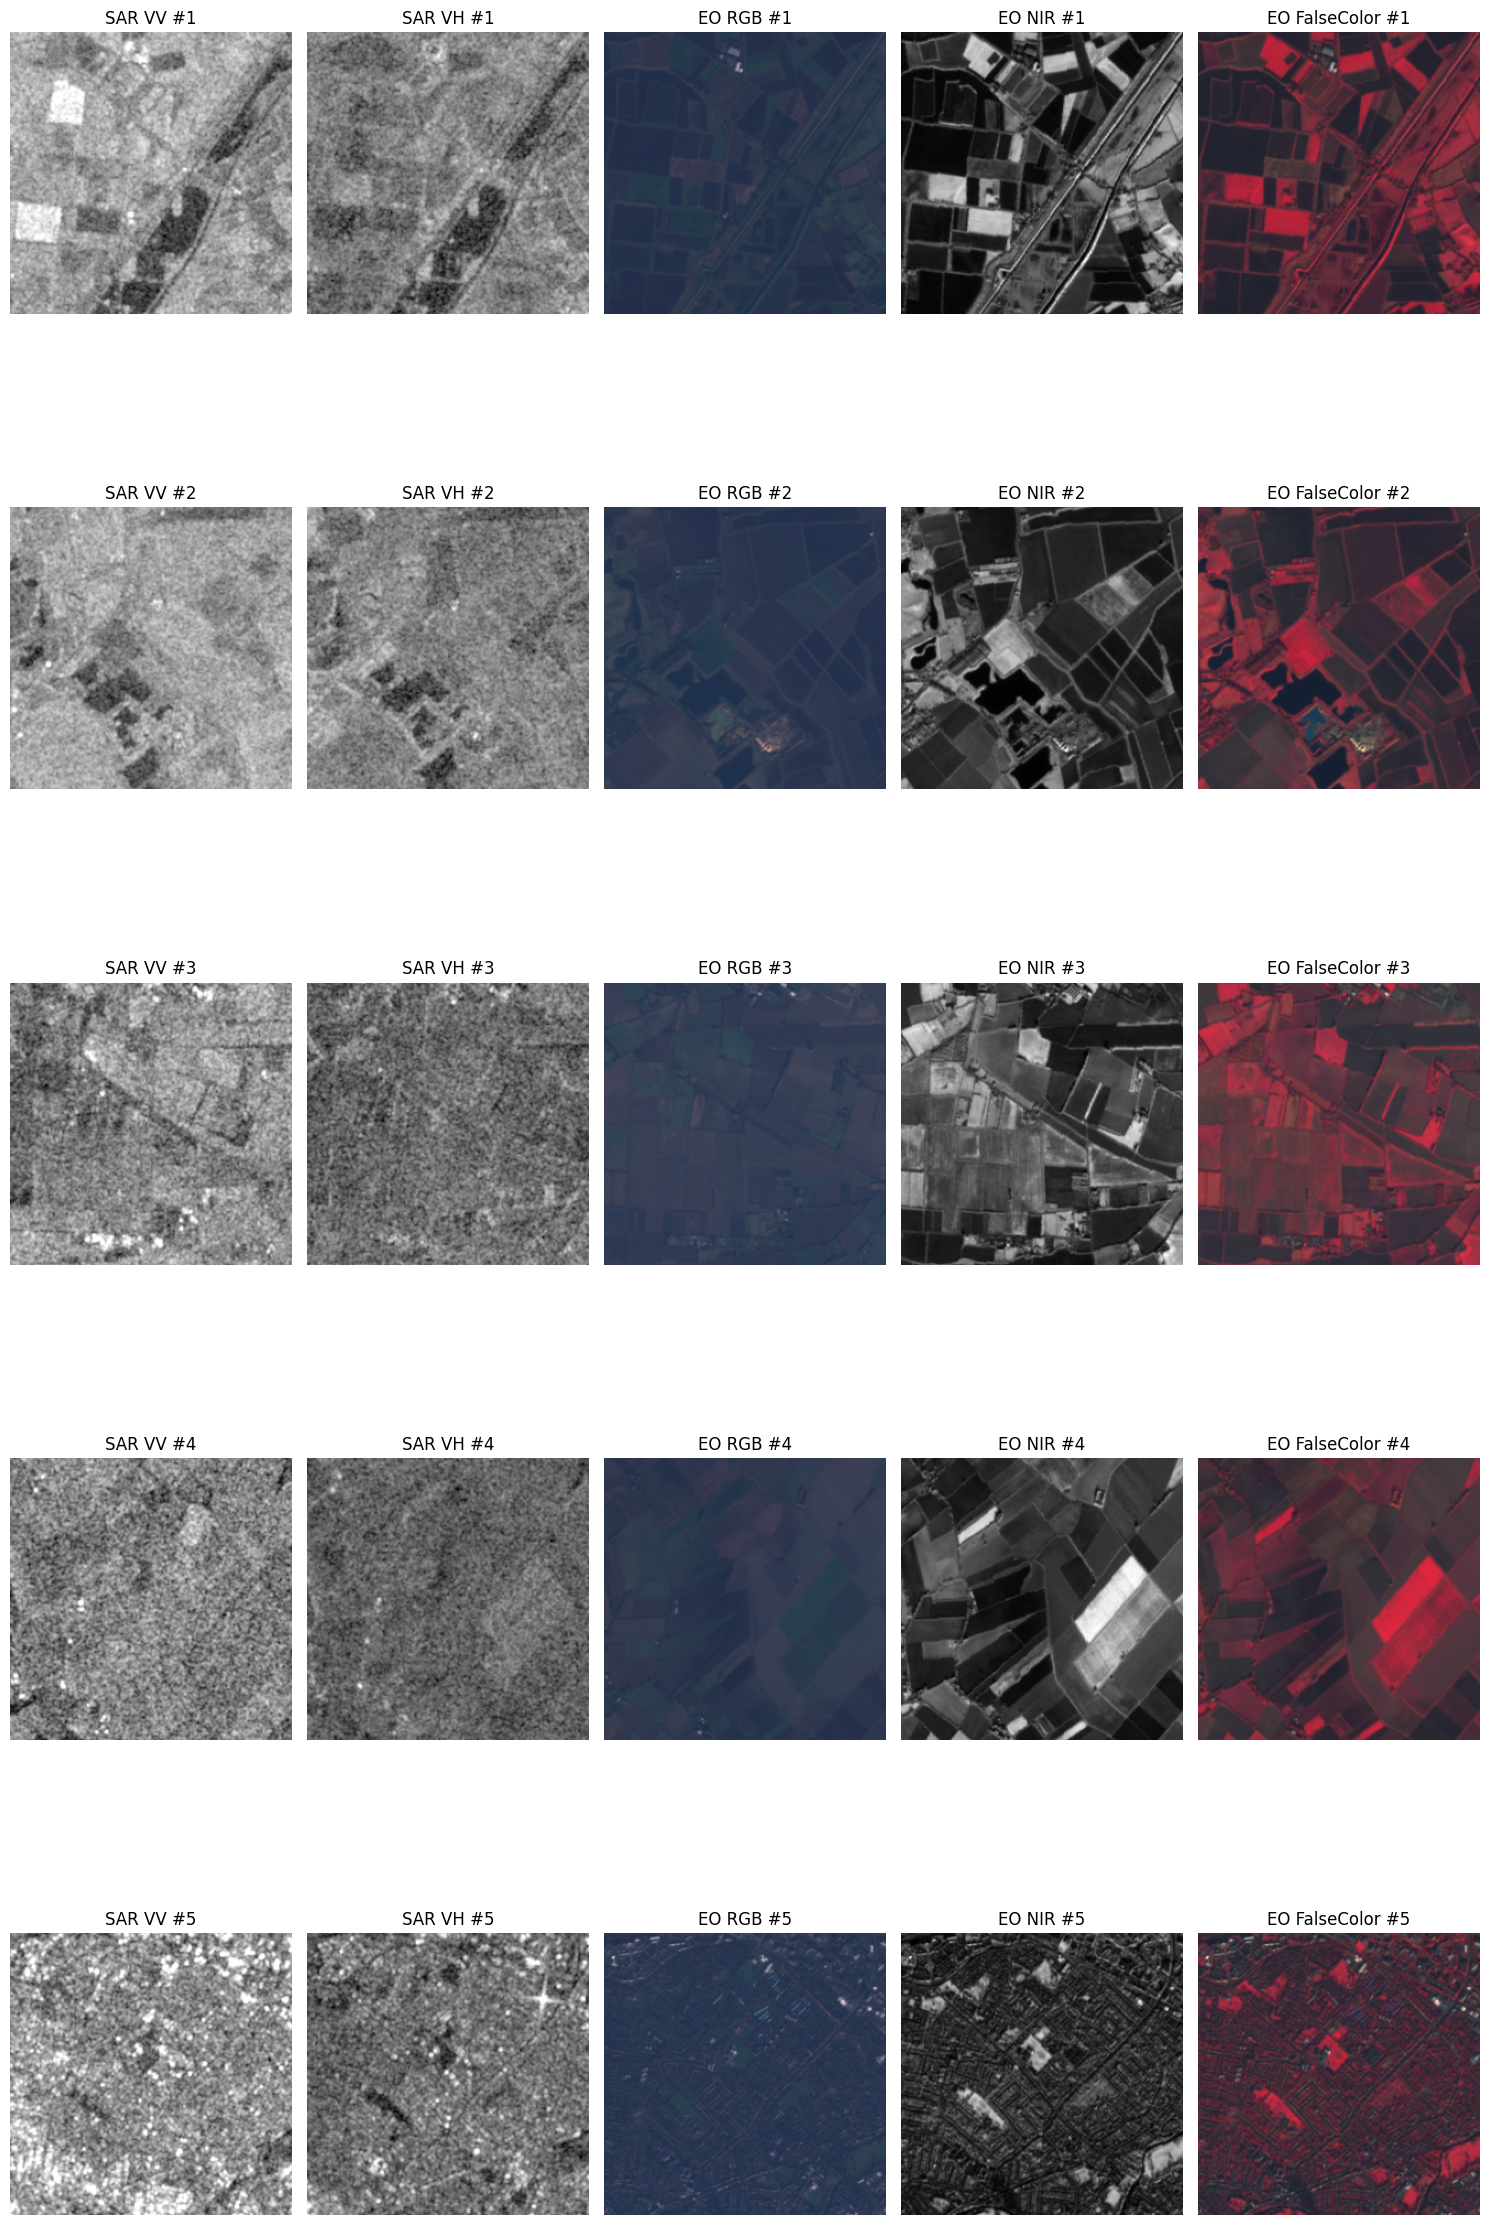

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

sar_dir = '/kaggle/working/processed_sar'
eo_dir  = '/kaggle/working/processed_eo'

sar_files = sorted(os.listdir(sar_dir))
eo_files  = sorted(os.listdir(eo_dir))

num_samples = 5
plt.figure(figsize=(15, num_samples * 5))

for i in range(num_samples):
    sar = np.load(os.path.join(sar_dir, sar_files[i]))  # (256,256,2)
    eo  = np.load(os.path.join(eo_dir,  eo_files[i]))   # (256,256,4)

    # SAR VV
    plt.subplot(num_samples, 5, 5*i+1)
    plt.imshow(sar[:,:,0], cmap='gray')
    plt.title(f"SAR VV #{i+1}"); plt.axis('off')

    # SAR VH
    plt.subplot(num_samples, 5, 5*i+2)
    plt.imshow(sar[:,:,1], cmap='gray')
    plt.title(f"SAR VH #{i+1}"); plt.axis('off')

    # EO RGB
    plt.subplot(num_samples, 5, 5*i+3)
    plt.imshow(np.clip(eo[:,:,:3],0,1))
    plt.title(f"EO RGB #{i+1}"); plt.axis('off')

    # EO NIR
    plt.subplot(num_samples, 5, 5*i+4)
    plt.imshow(eo[:,:,3], cmap='gray')
    plt.title(f"EO NIR #{i+1}"); plt.axis('off')

    # EO False Color (NIR,R,G)
    fc = np.stack([eo[:,:,3], eo[:,:,0], eo[:,:,1]], axis=-1)
    plt.subplot(num_samples, 5, 5*i+5)
    plt.imshow(np.clip(fc,0,1))
    plt.title(f"EO FalseColor #{i+1}"); plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import rasterio

with rasterio.open("/kaggle/input/sar2eo50/content/data_small/s1/ROIs2017_winter_s1_102_p134.tif") as src:
    print("Number of channels:", src.count)


Number of channels: 2


In [5]:
import torch
import numpy as np
import random
import torchvision.transforms.functional as TF

def normalize(img, mean, std):
    return (img - mean) / std

def apply_augment(img):
    # Random flip/rotation on numpy or tensor (works with both)
    if random.random()>0.5: img = TF.hflip(img)
    if random.random()>0.5: img = TF.vflip(img)
    angle = random.uniform(-15,15)
    return TF.rotate(img, angle)

def sar_transform(sar_np):
    # sar_np: (H,W,2)
    sar = torch.from_numpy(sar_np.transpose(2,0,1)).float()  # (2,H,W)
    sar = apply_augment(sar)
    return normalize(sar, mean=0.5, std=0.5)                # → [-1,1]

def eo_transform(eo_np):
    # eo_np: (H,W,4)
    eo = torch.from_numpy(eo_np.transpose(2,0,1)).float()    # (4,H,W)
    eo = apply_augment(eo)
    return normalize(eo, mean=0.5, std=0.5)                 # → [-1,1]


In [6]:
import os

def extract_key(fname):
    return "_".join(fname.split("_")[3:]).replace(".npy","")

sar_map = {
    extract_key(f): os.path.join(sar_dir, f)
    for f in os.listdir(sar_dir) if f.endswith(".npy")
}
eo_map  = {
    extract_key(f): os.path.join(eo_dir, f)
    for f in os.listdir(eo_dir) if f.endswith(".npy")
}

common_keys = sorted(set(sar_map)&set(eo_map))
sar_paths = [sar_map[k] for k in common_keys]
eo_paths  = [eo_map[k]  for k in common_keys]


In [7]:
from sklearn.model_selection import train_test_split

sar_train, sar_test, eo_train, eo_test = train_test_split(
    sar_paths, eo_paths, test_size=0.2, random_state=42
)


In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF
import random

class PairedTransform:
    def __init__(self, apply_augmentation=True):
        self.apply_augmentation = apply_augmentation

    def __call__(self, sar, eo):
        # Random Horizontal Flip
        if self.apply_augmentation and random.random() > 0.5:
            sar = TF.hflip(sar)
            eo  = TF.hflip(eo)

        # Random Vertical Flip
        if self.apply_augmentation and random.random() > 0.5:
            sar = TF.vflip(sar)
            eo  = TF.vflip(eo)

        # Random Rotation
        if self.apply_augmentation:
            angle = random.uniform(-15, 15)
            sar = TF.rotate(sar, angle)
            eo  = TF.rotate(eo, angle)

        return sar, eo

class SAR2EO_Dataset(Dataset):
    def __init__(self, sar_paths, eo_paths, paired_transform=None):
        self.sar_paths = sar_paths
        self.eo_paths = eo_paths
        self.paired_transform = paired_transform

    def __len__(self):
        return min(len(self.sar_paths), len(self.eo_paths))

    def __getitem__(self, idx):
        # Load .npy arrays
        sar_np = np.load(self.sar_paths[idx])  # (H, W, 2)
        eo_np  = np.load(self.eo_paths[idx])   # (H, W, 4)

        # Convert to torch tensors: (C, H, W)
        sar = torch.from_numpy(sar_np.transpose(2, 0, 1)).float()
        eo  = torch.from_numpy(eo_np.transpose(2, 0, 1)).float()

        # Normalize to [-1, 1]
        sar = (sar - 0.5) / 0.5
        eo  = (eo - 0.5) / 0.5

        # Apply pairwise transform
        if self.paired_transform:
            sar, eo = self.paired_transform(sar, eo)

        return sar, eo


In [9]:
from torch.utils.data import Dataset, DataLoader

# Define transforms
train_transform = PairedTransform(apply_augmentation=True)
test_transform  = PairedTransform(apply_augmentation=False)

# Train dataset and loader
train_dataset = SAR2EO_Dataset(sar_train, eo_train, train_transform)
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

# Test dataset and loader
test_dataset  = SAR2EO_Dataset(sar_test, eo_test, test_transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [10]:
import torch
import torch.nn as nn

# -----------------------------
# Residual Block
# -----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

# -----------------------------
# Generator (ResNet-based)
# -----------------------------
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features *= 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features //= 2

        # Final output
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------------
# Discriminator (PatchGAN)
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        in_features = 64
        out_features = in_features * 2
        for _ in range(3):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features *= 2

        model += [
            nn.Conv2d(in_features, 1, kernel_size=4, padding=1)
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------------
# Initialize Weights
# -----------------------------
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and ('Conv' in classname or 'Linear' in classname):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
import torch
import itertools
import os
from torch import nn, optim
from torchvision.utils import save_image

# ---------------------------
# Model setup
# ---------------------------
G_AB = ResNetGenerator(input_nc=2, output_nc=4).to(device)  # SAR (2ch) → EO (4ch)
G_BA = ResNetGenerator(input_nc=4, output_nc=2).to(device)  # EO (4ch) → SAR (2ch)

D_A = Discriminator(input_nc=2).to(device)  # Discriminates SAR (2ch)
D_B = Discriminator(input_nc=4).to(device)  # Discriminates EO (4ch)

init_weights(G_AB)
init_weights(G_BA)
init_weights(D_A)
init_weights(D_B)

# ---------------------------
# Losses and Optimizers
# ---------------------------
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
criterion_L1 = nn.L1Loss()  # 🔸 Added L1 loss for paired supervision

lambda_L1 = 100  # 🔸 Weight for L1 loss between fake EO and real EO

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# ---------------------------
# Training
# ---------------------------
epochs = 10
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    for i, (real_A, real_B) in enumerate(train_loader):
        real_A = real_A.to(device)  # SAR image tensor (2-ch)
        real_B = real_B.to(device)  # EO image tensor  (4-ch)

        # ---------------------------
        # Train Generators
        # ---------------------------
        optimizer_G.zero_grad()

        # # Identity loss
        # loss_idt_A = criterion_identity(G_BA(real_A), real_A) * 5.0
        # loss_idt_B = criterion_identity(G_AB(real_B), real_B) * 5.0

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))

        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        # Cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A) * 10.0
        loss_cycle_B = criterion_cycle(recov_B, real_B) * 10.0

        # 🔸 L1 loss (paired supervision): fake EO should match real EO
        loss_L1_EO = criterion_L1(fake_B, real_B) * lambda_L1

        # Total generator loss
        loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B + loss_L1_EO
        loss_G.backward()
        optimizer_G.step()

        # ---------------------------
        # Train Discriminator A (SAR)
        # ---------------------------
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
        loss_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---------------------------
        # Train Discriminator B (EO)
        # ---------------------------
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
        loss_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # ---------------------------
        # Logging
        # ---------------------------
        if i % 20 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(train_loader)}] "
                  f"[G: {loss_G.item():.4f}] [D_A: {loss_D_A.item():.4f}] [D_B: {loss_D_B.item():.4f}]")

    # ---------------------------
    # Save checkpoints
    # ---------------------------
    torch.save(G_AB.state_dict(), os.path.join(checkpoint_dir, f"G_AB_epoch{epoch+1}.pth"))
    torch.save(G_BA.state_dict(), os.path.join(checkpoint_dir, f"G_BA_epoch{epoch+1}.pth"))
    torch.save(D_A.state_dict(), os.path.join(checkpoint_dir, f"D_A_epoch{epoch+1}.pth"))
    torch.save(D_B.state_dict(), os.path.join(checkpoint_dir, f"D_B_epoch{epoch+1}.pth"))


[Epoch 1/10] [Batch 1/160] [G: 72.4177] [D_A: 2.4082] [D_B: 1.5101]
[Epoch 1/10] [Batch 21/160] [G: 33.4348] [D_A: 1.2543] [D_B: 0.6067]
[Epoch 1/10] [Batch 41/160] [G: 23.8076] [D_A: 0.8927] [D_B: 0.4949]
[Epoch 1/10] [Batch 61/160] [G: 24.4310] [D_A: 0.5834] [D_B: 0.2733]
[Epoch 1/10] [Batch 81/160] [G: 28.5368] [D_A: 0.7236] [D_B: 0.1628]
[Epoch 1/10] [Batch 101/160] [G: 25.5086] [D_A: 0.6123] [D_B: 0.3183]
[Epoch 1/10] [Batch 121/160] [G: 46.7488] [D_A: 0.2721] [D_B: 0.2163]
[Epoch 1/10] [Batch 141/160] [G: 24.7988] [D_A: 0.3081] [D_B: 0.1224]
[Epoch 2/10] [Batch 1/160] [G: 16.4955] [D_A: 0.3536] [D_B: 0.1190]
[Epoch 2/10] [Batch 21/160] [G: 14.4915] [D_A: 0.2871] [D_B: 0.0961]
[Epoch 2/10] [Batch 41/160] [G: 12.9431] [D_A: 0.2318] [D_B: 0.0682]
[Epoch 2/10] [Batch 61/160] [G: 16.8059] [D_A: 0.2035] [D_B: 0.2411]
[Epoch 2/10] [Batch 81/160] [G: 38.2105] [D_A: 0.2520] [D_B: 0.0700]
[Epoch 2/10] [Batch 101/160] [G: 24.7634] [D_A: 0.7705] [D_B: 0.5588]
[Epoch 2/10] [Batch 121/160] [G:

In [13]:
from torchvision.utils import save_image

# Generator: SAR (2ch) → EO (4ch)
G_A2B = ResNetGenerator(input_nc=2, output_nc=4).to(device)
G_A2B.load_state_dict(torch.load('/kaggle/working/checkpoints/G_AB_epoch10.pth', map_location=device))
G_A2B.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

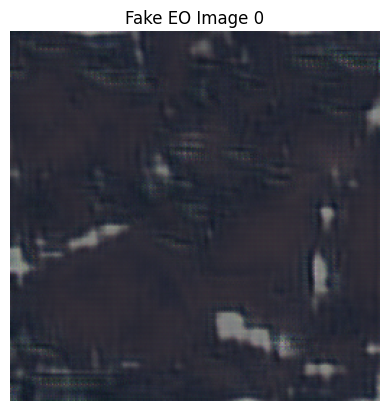

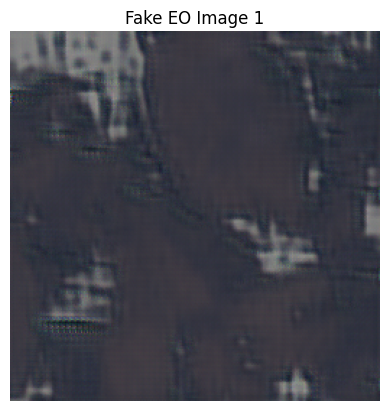

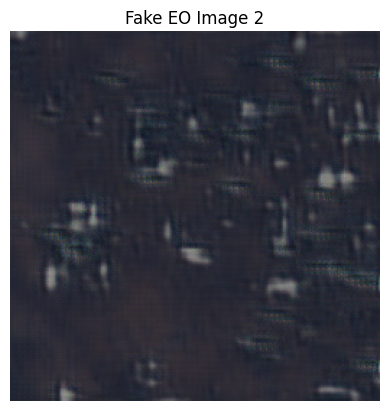

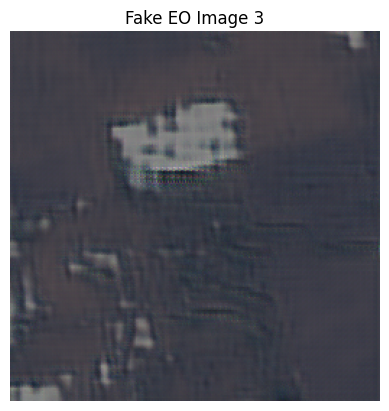

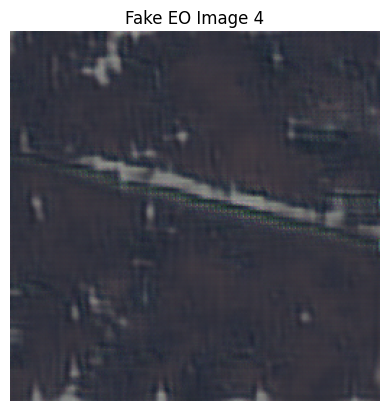

In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Load generator trained for SAR (2ch) → EO (4ch)
netG_A = ResNetGenerator(input_nc=2, output_nc=4).to(device)
netG_A.load_state_dict(torch.load('checkpoints/G_AB_epoch10.pth', map_location=device))
netG_A.eval()

# Inference loop
for i, (sar_image, _) in enumerate(test_loader):  # Only SAR needed for generation
    sar_image = sar_image.to(device)

    with torch.no_grad():
        fake_eo = netG_A(sar_image)  # SAR → fake EO

    # Denormalize from [-1, 1] to [0, 1]
    fake_eo = (fake_eo + 1) / 2.0
    np_img = fake_eo.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Show only RGB channels (first 3 of 4)
    plt.imshow(np.clip(np_img[..., :3], 0, 1))
    plt.title(f'Fake EO Image {i}')
    plt.axis('off')
    plt.show()

    # Optionally save output
    # save_image(fake_eo, f"outputs/fake_eo_{i}.png")

    if i == 4:
        break


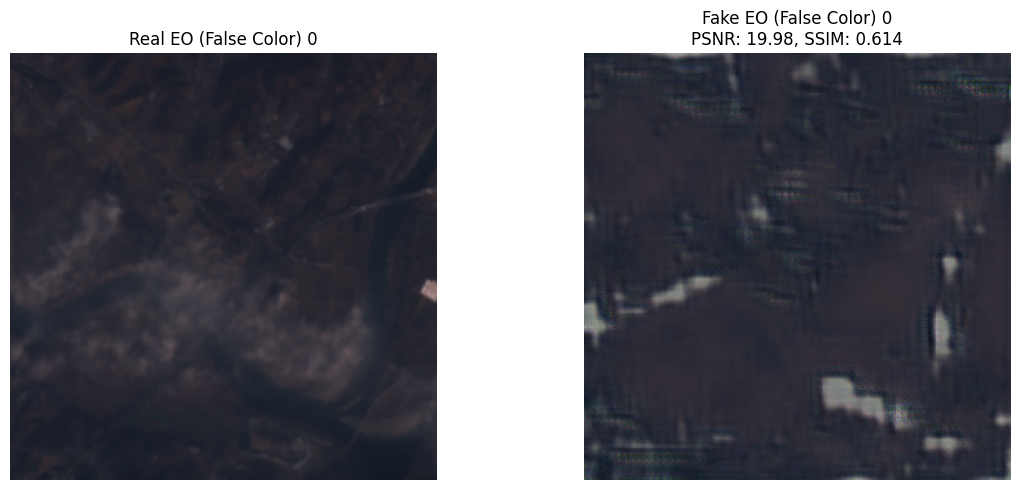

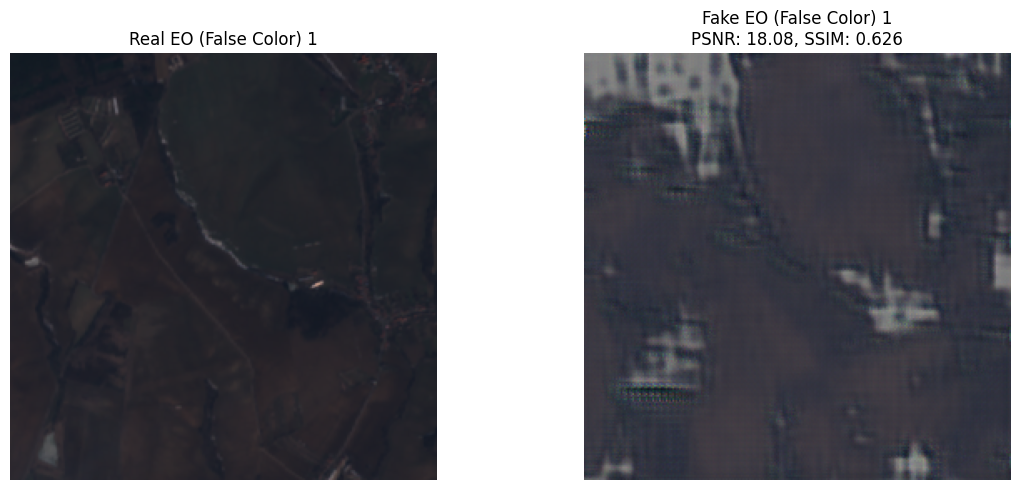

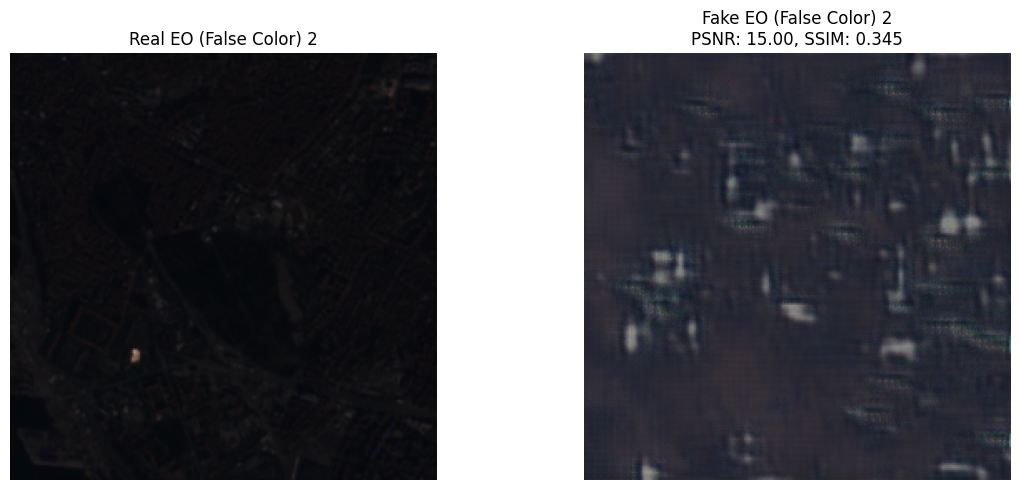

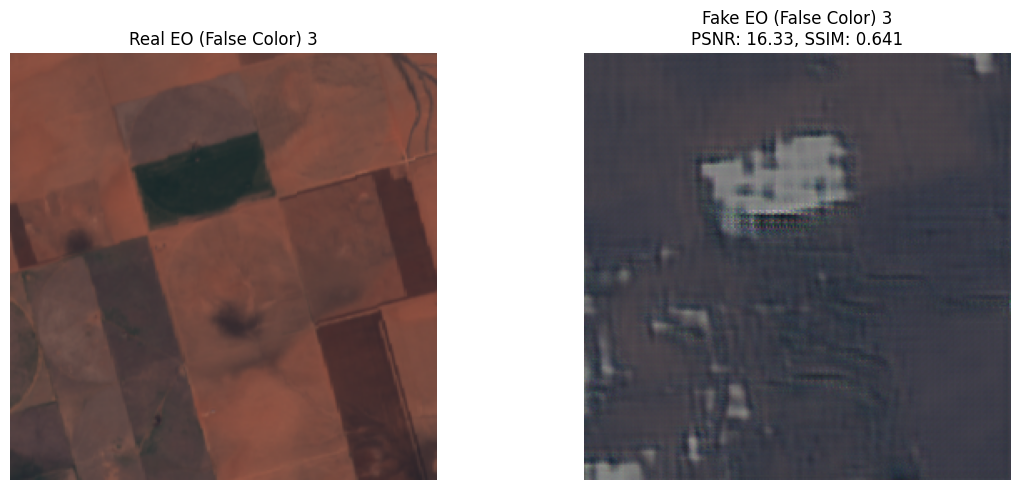

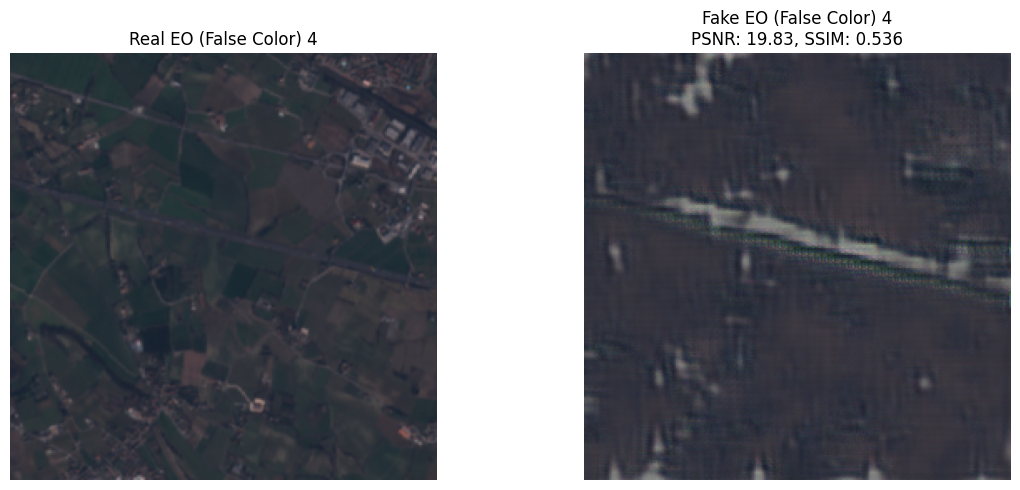

Average PSNR on test set: 16.68
Average SSIM on test set: 0.4930


In [15]:
!pip install scikit-image
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
import matplotlib.pyplot as plt

netG_A.eval()  # evaluation mode

psnr_values = []
ssim_values = []

for i, (sar_image, real_eo) in enumerate(test_loader):
    sar_image = sar_image.to(device)
    real_eo = real_eo.to(device)

    with torch.no_grad():
        fake_eo = netG_A(sar_image)

    # Denormalize from [-1,1] to [0,1]
    fake_eo_np = (fake_eo + 1) / 2.0
    real_eo_np = (real_eo + 1) / 2.0

    # Convert to CPU numpy and transpose to HWC
    fake_eo_np = fake_eo_np.squeeze().cpu().numpy().transpose(1, 2, 0)
    real_eo_np = real_eo_np.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Clip to [0,1]
    fake_eo_np = np.clip(fake_eo_np, 0, 1)
    real_eo_np = np.clip(real_eo_np, 0, 1)

    # Compute PSNR and SSIM
    psnr_val = compare_psnr(real_eo_np, fake_eo_np, data_range=1.0)
    ssim_val = compare_ssim(real_eo_np, fake_eo_np, data_range=1.0, channel_axis=2, win_size=5)

    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

    # Visualize first few using NIR → R, R → G, G → B
    if i < 5:
        real_false = np.stack([
            real_eo_np[:, :, 0],  # NIR → R
            real_eo_np[:, :, 1],  # R → G
            real_eo_np[:, :, 2],  # G → B
        ], axis=-1)

        fake_false = np.stack([
            fake_eo_np[:, :, 0],  # NIR → R
            fake_eo_np[:, :, 1],  # R → G
            fake_eo_np[:, :, 2],  # G → B
        ], axis=-1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(real_false)
        plt.title(f"Real EO (False Color) {i}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(fake_false)
        plt.title(f"Fake EO (False Color) {i}\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.3f}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print(f"Average PSNR on test set: {np.mean(psnr_values):.2f}")
print(f"Average SSIM on test set: {np.mean(ssim_values):.4f}")
